In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
data_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/output/psf_dataset/'
wf_psf_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/wf-psf/'

# SED folder path
SED_path = wf_psf_dir+'data/SEDs/save_SEDs/'

# Load the datasets
dataset_train = np.load(data_dir + 'train_10000_stars_id_001_8bins.npy', allow_pickle=True)[()]
print(dataset_train.keys())
dataset_test = np.load(data_dir + 'test_1000_stars_id_001_8bins.npy', allow_pickle=True)[()]

dict_keys(['stars', 'noisy_stars', 'mono_psfs', 'positions', 'SEDs', 'zernike_coef', 'C_poly', 'parameters', 'SED_ids', 'SNR'])


In [3]:
noisy = True
if noisy == True:
    obs_type = 'noisy_stars'
else:
    obs_type = 'stars'

# Compute the star spectral energy distribution estimation
diff_train = []
for i in range(dataset_train['parameters']['n_stars']):
    diff = (np.array([np.sum((mono_psf-dataset_train[obs_type][i])**2) for mono_psf in dataset_train['mono_psfs'][i]]))
    diff_train.append((1-diff)/np.max(1-diff))
diff_train = np.array(diff_train)
print(diff_train.shape)

diff_test = []
for i in range(dataset_test['parameters']['n_stars']):
    diff = (np.array([np.sum((mono_psf-dataset_test[obs_type][i])**2) for mono_psf in dataset_test['mono_psfs'][i]]))
    diff_test.append((1-diff)/np.max(1-diff))
diff_test = np.array(diff_test)
print(diff_test.shape)

(10000, 8)
(1000, 8)


In [4]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(diff_train, dataset_train['SED_ids'])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [5]:
predictions = clf.predict(diff_test)

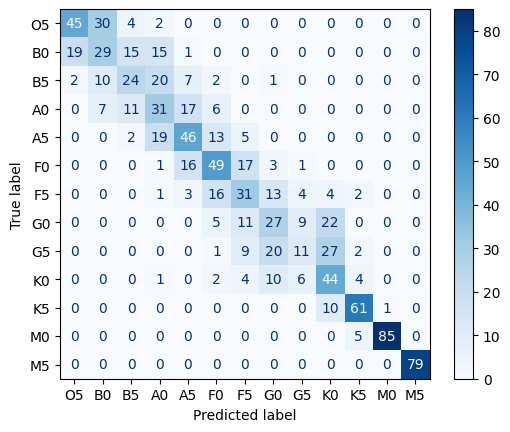

In [6]:
star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']
cm = confusion_matrix(dataset_test['SED_ids'], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=star_class_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [7]:
accuracy = np.trace(cm)/np.sum(cm)
relaxed_accuracy = (np.trace(cm, offset=1) + np.trace(cm, offset=-1) + np.trace(cm) )/np.sum(cm)

print('Accuracy: ', accuracy)
print('Relaxed accuracy: ', relaxed_accuracy)

Accuracy:  0.562
Relaxed accuracy:  0.871
